# Variant Call Adjacency Matrix


An interconnected matrix of variants from data in 1000 genomes.


# GA4GH Server Connection Established

Here, like the 1kg example, a client object is used to communicate with the server.

In [1]:
from __future__ import print_function
import ga4gh.client as client
data = client.HttpClient("http://1kgenomes.ga4gh.org")

import collections
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Data Sets 

In [2]:
datasets = list(data.searchDatasets())
print("Datasets")
for dataset in datasets:
    print("Name: {}".format(dataset.name))

Datasets
Name: 1kgenomes


In [3]:
dataset = data.getDataset(datasets[0].id)

In [4]:
release = None
functional = None
for variantSet in data.searchVariantSets(datasetId=dataset.id):
    if variantSet.name == "phase3-release":
        release = variantSet
    else:
        functional = variantSet

In [5]:
callsi = list(data.searchCallSets(release.id))

variantSets = list(data.searchVariantSets(dataset.id))
variantSetId = variantSets[0].id
x = data.searchVariants(variantSetId, start=100000, end=140000, 
    referenceName = "1").next()

call_set_ids = []

for csi in callsi:        
    call_set_ids.append(csi.id)

# generate_dictionary function

generates a dictionary of call set id keys and values for the index of that the call set id appeared throughout a list of variants within a given range on the human genome

In [6]:
def generate_dictionary():
    
    dictionary = {}
    
    variants = data.searchVariants(variantSetId, callSetIds= call_set_ids[0:40],
           start=100000, end=140000, referenceName = "1" )
    
    i = 0
    for v in variants:
        for call_inner in v.calls:
            i += 1
            dictionary[call_inner.call_set_id] = i
    
    return (dictionary)  

# normalize_indexes function

initializes the indexes of the variant dictionay to be {0,...,n} where n is the number of call set ids 

In [7]:
def normalize_indexes(dictionary):
       
    keys = []
    keys = dictionary.keys()
    
    new_dictionary = {}
    i = 0
    j = 0
    k = 0
    for i in range(len(dictionary)):        
        l = keys[j]
        dictionary[l] = k
        j += 1
        k += 1
    
    return dictionary

In [13]:
dictionary = generate_dictionary()
print()
normalize_indexes(dictionary)

{u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDA5NiJd': 20,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDA5NyJd': 14,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDA5OSJd': 8,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDE0MCJd': 17,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMCJd': 27,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMSJd': 15,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMiJd': 34,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwMyJd': 38,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwNSJd': 30,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwNiJd': 5,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwNyJd': 1,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwOCJd': 32,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDEwOSJd': 6,
 u'WyIxa2dlbm9tZXMiLCJ2cyIsInBoYXNlMy1yZWxlYXNlIiwiSEcwMDExMCJd': 36,
 u'WyIxa2dlbm9tZXMiLCJ2c

# variant_matrix function

This function connects two identical sets of participant sample's callSetId's through the variants shared between them.

                     M D (Mother/Father allele donated)
    Where A or B =  [1,0] : heterozygous for variant
                    [0,1] : heterozygous for variant
                    [1,1] : homozygous dominant for variant
                    [0,0] : homozygous recessive for variant
                 
         1     |  0    |
      1 |[1,1] | [1,0] |
        |      |       |      
      0 |[1,0] | [0,0] |
    
    
    True for the shared genotype:
        
        case 1: 
            A = [1,0]
            B = [0,1]
        case 2: 
            A = [0,0]
            B = [0,0]
        case 3:  
            A = [1,0]
            B = [1,0]
        case 4: 
            A = [1,1]
            B = [0,1]
    
    False for the shared genotype:
        
        case 1: 
            A = [1,0]
            B = [0,0]
        case 2:
            A = [0,1]
            B = [0,0]
        case 3: 
            A = [0,0]
            B = [1,0]
        case 4:
            A = [0,0]
            B = [0,1]
            
            

In [133]:
def variant_matrix(callMatrix):
        
    csid_dict = {}    
    csid_dict = generate_dictionary() 
    
    normalize_indexes(csid_dict)
    
    h = len(dictionary)
    w = len(dictionary)
    dimension = h*w
    
    callMatrix = [[0 for x in range(w)] for y in range(h)]    
    np.zeros(dimension)     
    
    vs = data.searchVariants(variantSetId, callSetIds= call_set_ids[0:40],
           start=100000, end=140000, referenceName = "1")

    for v in vs:
        for call_outer in v.calls:         
            for call_inner in v.calls:               
                outer_index = csid_dict[call_outer.call_set_id] 
                inner_index = csid_dict[call_inner.call_set_id]                             
                # can be 0 or 1
                A1 = call_outer.genotype[0] 
                A2 = call_outer.genotype[1]
                B1 = call_inner.genotype[0]
                B2 = call_inner.genotype[1]               
                # True for the shared genotype
                if (((A1 + A2 ) > 0) and ((B1 + B2) > 0)):
                    callMatrix[outer_index][inner_index] += 1
                elif (((A1 + A2 ) == 0) and ((B1 + B2) == 0)):
                    callMatrix[outer_index][inner_index] += 1               
                
    return (callMatrix)

In [134]:
matrix = {}
variant_matrix(matrix)

[[193,
  191,
  190,
  191,
  191,
  192,
  191,
  192,
  191,
  189,
  192,
  191,
  191,
  188,
  191,
  190,
  190,
  191,
  190,
  191,
  190,
  193,
  191,
  190,
  191,
  192,
  191,
  193,
  192,
  191,
  190,
  191,
  189,
  191,
  192,
  190,
  192,
  191,
  191,
  190],
 [191,
  193,
  190,
  193,
  191,
  192,
  191,
  192,
  193,
  191,
  192,
  193,
  193,
  188,
  193,
  192,
  192,
  191,
  192,
  193,
  192,
  191,
  191,
  190,
  193,
  192,
  193,
  191,
  192,
  193,
  190,
  191,
  187,
  193,
  192,
  190,
  192,
  191,
  193,
  192],
 [190,
  190,
  193,
  190,
  190,
  191,
  192,
  191,
  190,
  190,
  189,
  190,
  190,
  187,
  190,
  189,
  189,
  192,
  191,
  190,
  189,
  190,
  192,
  191,
  190,
  191,
  190,
  190,
  191,
  190,
  191,
  190,
  186,
  190,
  191,
  187,
  191,
  190,
  190,
  189],
 [191,
  193,
  190,
  193,
  191,
  192,
  191,
  192,
  193,
  191,
  192,
  193,
  193,
  188,
  193,
  192,
  192,
  191,
  192,
  193,
  192,
  191,
  1

# visualize_matrix function 

In [135]:
def visualize_matrix_color(callMatrix):
    
    callMatrix = variant_matrix(callMatrix)
    
    fig = plt.figure(1,(10.,10.))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    
    ax = grid[0]
    ax.imshow(callMatrix, origin = "lower", interpolation="nearest")
    
    #plt.draw()
    plt.show()

def visualize_matrix_grey(callMatrix):
    
    callMatrix = variant_matrix(callMatrix)
    
    fig = plt.figure(1,(10.,10.))
    grid = ImageGrid(fig, 111,
                    nrows_ncols=(1,1),
                    axes_pad=0.1)
    ax = grid[0]
    ax.imshow(callMatrix, cmap= 'Greys', origin = "lower", interpolation="nearest")
    
    #plt.draw()  
    plt.show()

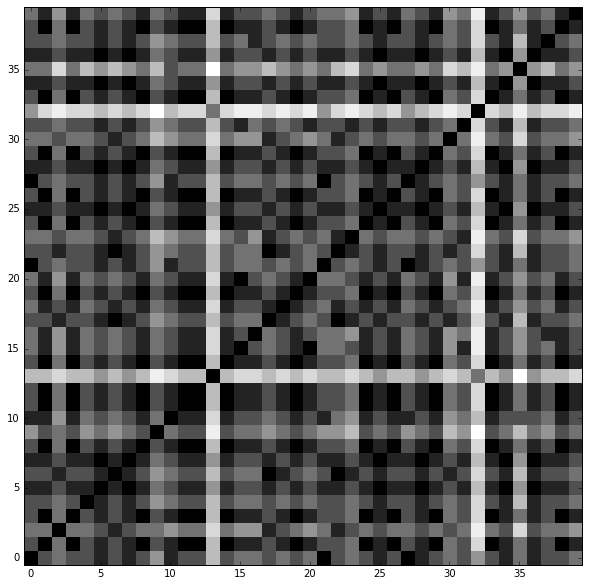

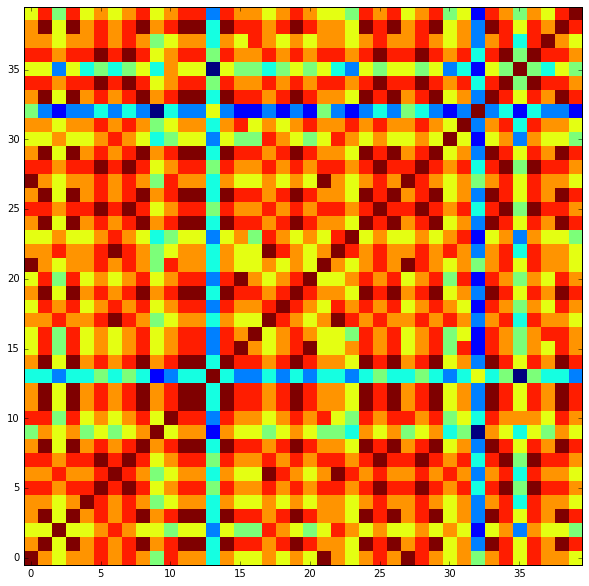

In [136]:
matrix = {}
visualize_matrix_grey(matrix)
visualize_matrix_color(matrix)

In [ ]:
def determine_matrix_range():
    
    matrix = {}
    matrix = variant_matrix(matrix)
    
    i = 0
    j = 0
    cur = 0
    lis = []
    
    for i in range(len(matrix)):
        for j in range(len(matrix)):
            cur = matrix[i][j]
            lis.append(cur)
            
    minimum = min(lis)
    maximum = max(lis)
    print ("values in the matrix range from {} to {}".
           format(minimum, maximum))
    lis.sort()

    return lis

In [139]:
def find_percent_occurence():
    
    lis = []
    lis = determine_matrix_range()
        
    occurence_dict = {}    

    variable = lis[0]
    k = 0

    for i in lis:
        
        if (i == variable):
            
        #if ( variable == k):
        #    occurence_dict[variable] += 1  
        #elif( k < variable):
        #    k += 1
        #else:
        #    variable += 1
            
    return occurence_dict


In [140]:
find_percent_occurence()

values in the matrix range from 185 to 193
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi
hi


{}